##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 多变化点检测和贝叶斯模型选择


# 贝叶斯模型选择

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 Tensorflow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

## 导入

In [ ]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

## 任务：具有多个变化点的变化点检测

假设有一个变化点检测任务：事件发生的比率随时间变化，驱动因素是某个生成数据的系统或过程（未观察到）的状态突然发生变化。

例如，我们可能会观察一系列如下所示的计数：

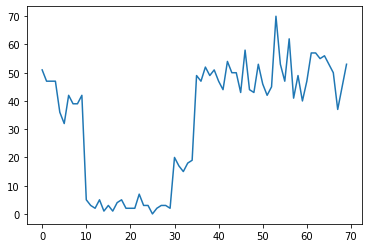

In [ ]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

observed_counts = tf.concat(
    [tfd.Poisson(rate).sample(num_steps)
     for (rate, num_steps) in zip(true_rates, true_durations)], axis=0)

plt.plot(observed_counts)

这些计数可以表示数据中心出现故障的次数、网页的访问者人数、网络链路上的数据包数，等等。

请注意，仅通过查看数据，无法完全了解有多少种不同的系统体制。您知道三个切换点中的每一个出现在哪里吗？

## 已知状态数

我们首先考虑的情况（可能不现实）是，未观察到的状态数称为先验。此时，我们假定我们知道有四种隐状态。

我们将此问题建模为切换（非均质）泊松过程：在每个时间点，发生的事件数按泊松分布，事件*比率*取决于未观察到的系统状态 $z_t$：

$$x_t \sim \text{Poisson}(\lambda_{z_t})$$

隐状态为离散值：$z_t \in {1, 2, 3, 4}$，因此，$\lambda = [\lambda_1, \lambda_2, \lambda_3, \lambda_4]$ 是包含每种状态的泊松比的简单向量。为了对状态随时间的演变进行建模，我们定义一个简单的转移模型 $p(z_t | z_{t-1})$：我们假定在每一步保持前一种状态的概率为 $p$，那么我们随机均匀转移到其他状态的概率为 $1-p$。初始状态也是随机均匀进行选择，因此，我们使用：

$$ \begin{align*} z_1 &amp;\sim \text{Categorical}\left(\left{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right}\right)\ z_t | z_{t-1} &amp;\sim \text{Categorical}\left(\left{\begin{array}{cc}p &amp; \text{if } z_t = z_{t-1} \ \frac{1-p}{4-1} &amp; \text{otherwise}\end{array}\right}\right) \end{align*}$$

上述假设对应于具有泊松发射的[隐马尔可夫模型](http://mlg.eng.cam.ac.uk/zoubin/papers/ijprai.pdf)。我们可以使用 `tfd.HiddenMarkovModel` 在 TFP 中对这些假设进行编码。首先，我们在初始状态中定义转移矩阵和均匀先验：

In [ ]:
num_states = 4
initial_state_logits = tf.zeros([num_states]) # uniform distribution

daily_change_prob = 0.05
transition_probs = tf.fill([num_states, num_states],
                           daily_change_prob / (num_states - 1))
transition_probs = tf.linalg.set_diag(transition_probs,
                                      tf.fill([num_states],
                                              1 - daily_change_prob))

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


接着，我们构建 `tfd.HiddenMarkovModel` 分布，使用可训练变量来表示与每种系统状态关联的比率。我们在对数空间中对比率进行参数化，确保比率为正值。

In [ ]:
# Define variable to represent the unknown log rates.
trainable_log_rates = tf.Variable(
  tf.math.log(tf.reduce_mean(observed_counts)) +
  tf.random.stateless_normal([num_states], seed=(42, 42)),
  name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

最后，我们定义模型的总对数密度（包括比率的弱信息对数正态先验），并运行优化器来计算与观察的计数数据拟合的[最大后验概率](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP)。

Text(0, 0.5, 'Negative log marginal likelihood')

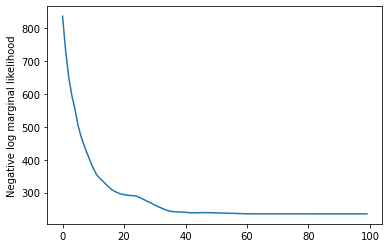

In [ ]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

In [ ]:
rates = tf.exp(trainable_log_rates)
print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rates))

Inferred rates: [ 2.8302798 49.58499   41.928307  17.35112  ]
True rates: [40, 3, 20, 50]


起作用了！请注意，此模型中的隐状态最多只能识别到置换，因此，我们重新获得的比率按不同的顺序分布，虽然有一些噪音，但它们通常匹配得很不错。

### 重新获得状态轨迹

由于我们拟合了模型，我们可能需要重新构造模型认为系统在每个时间步骤中所处的*状态*。

这就是*后验推断*任务：假定观察到的计数为 $x_{1:T}$，模型参数（比率）为 $\lambda$，我们需要按照后验分布 $p(z_{1:T} | x_{1:T}, \lambda)$ 来推断离散隐变量的序列。在隐马尔可夫模型中，我们可以使用标准消息传递算法有效地计算此分布的边缘概率和其他属性。特别要说的是，`posterior_marginals` 方法可以有效计算（使用[前向-后向算法](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm)）每个时间步骤 $t$ 中离散隐状态 $Z_t$ 的边缘概率分布 $p(Z_t = z_t | x_{1:T})$。

In [ ]:
# Runs forward-backward algorithm to compute marginal posteriors.
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()

通过绘制后验概率，我们重新获得模型对数据的“说明”：每种状态在哪些时间点会激活？

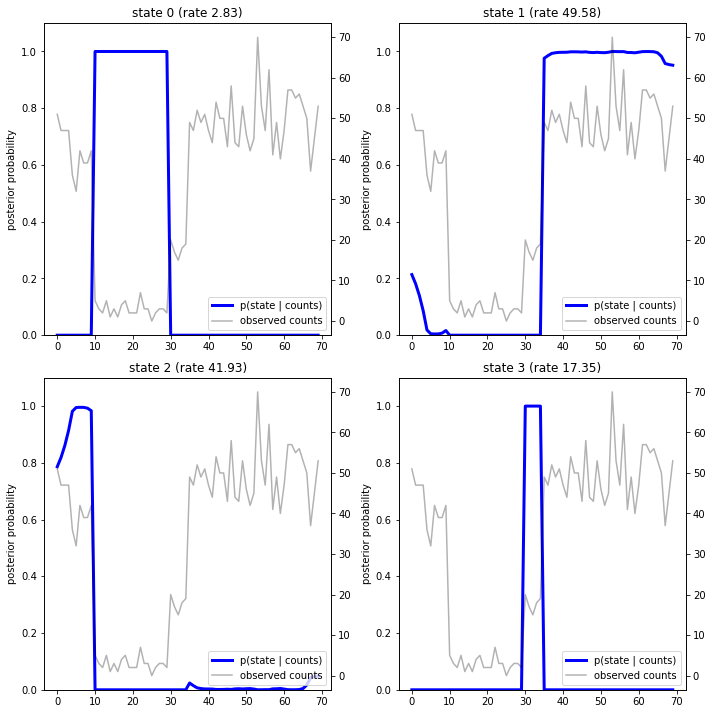

In [ ]:
def plot_state_posterior(ax, state_posterior_probs, title):
  ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
  ax.set_ylim(0., 1.1)
  ax.set_ylabel('posterior probability')
  ax2 = ax.twinx()
  ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax2.set_title(title)
  ax2.set_xlabel("time")
  lns = ln1+ln2
  labs = [l.get_label() for l in lns]
  ax.legend(lns, labs, loc=4)
  ax.grid(True, color='white')
  ax2.grid(False)

fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs[:, 0],
                     title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs[:, 1],
                     title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs[:, 2],
                     title="state 2 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4),
                     posterior_probs[:, 3],
                     title="state 3 (rate {:.2f})".format(rates[3]))
plt.tight_layout()

在这个（简单）示例中，我们发现模型通常很自信：在大多数时间步骤中，模型基本上会将所有概率质量分配给四种状态之一。幸运的是，这些说明看起来合情合理！

在每个时间步骤中，我们还可以根据与*最有可能的*隐状态相关的比率来呈现这个后验概率，从而将概率后验浓缩为一种说明：

In [ ]:
most_probable_states = hmm.posterior_mode(observed_counts)
most_probable_rates = tf.gather(rates, most_probable_states)

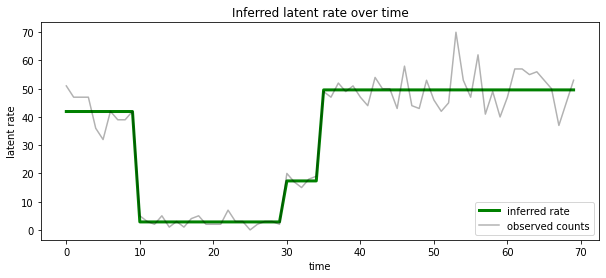

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

## 未知状态数

在实际问题中，我们可能并不知道我们所建模的系统中状态的“真实”数量。这可能不一定是一个问题：如果您不是特别在意未知状态的特性，您可能只是运行一个模型，其中的状态数量超过了您知道模型所需要的状态数量，并学习（有点像）实际状态的一堆重复副本。不过，我们假设您很在意推断隐状态的“真实”数量。

我们可以将这种情况视为[贝叶斯模型选择](http://alumni.media.mit.edu/~tpminka/statlearn/demo/)的一个案例：我们有一组候选模型，其中每个模型包含不同数量的隐状态；我们需要选择一个模型，它最有可能生成了观察到的数据。为此，我们根据每个模型计算数据的边缘似然（我们也可以在模型本身中添加先验，但在此分析中不必要；如果对更简单的模型进行编码，[贝叶斯奥卡姆剃刀](https://www.cs.princeton.edu/courses/archive/fall09/cos597A/papers/MacKay2003-Ch28.pdf)就足够了）。

遗憾的是，真实边缘似然对离散状态 $z_{1:T}$ 和比率参数（的向量） $\lambda$, $$p(x_{1:T}) = \int p(x_{1:T}, z_{1:T}, \lambda) dz d\lambda,$$ 同时积分，对于此模型不易处理。为方便起见，我们将使用所谓的“[经验贝叶斯](https://www.cs.ubc.ca/~schmidtm/Courses/540-W16/L19.pdf)”或“第二类极大似然”估计来逼近它：我们将优化与每种系统状态关联的（未知）比率参数 $\lambda$ 的值，而不是完全积分这些参数：

$$\tilde{p}(x_{1:T}) = \max_\lambda \int p(x_{1:T}, z_{1:T}, \lambda) dz$$

这种逼近可能会过度拟合，即，它将偏向于比真实边缘似然所需模型更复杂的模型。我们可以考虑较为准确可靠的逼近，例如，优化变化的下限，或者使用蒙特卡洛估计器，例如，[退火重要性采样](https://tensorflow.google.cn/probability/api_docs/python/tfp/mcmc/sample_annealed_importance_chain)；（可惜）这些内容超出了本笔记本讨论的范畴。（有关贝叶斯模型选择和逼近的详细信息，请参阅[机器学习：概率视角](https://www.cs.ubc.ca/~murphyk/MLbook/)的第 7 章，该部分内容非常精彩，可以为您提供不错的参考。）

原则上，我们只需使用不同的 `num_states` 值多次重新运行上述优化，即可完成此模型比较，但工作量比较大。下面，我们将展示如何使用 TFP 的 `batch_shape` 向量化机制同时考虑多个模型。

**转移矩阵和初始状态先验**：现在，我们不构建单个模型说明，而是构建一*批*转移矩阵和先验 logits，其中每一个转移矩阵和先验 logits 对应于一个候选模型（候选模型最多为 `max_num_states`）。为了便于批处理，我们需要确保所有计算采用相同的“形状”：它必须对应于我们要拟合的最大模型的维度。为了处理较小的模型，我们可以将其说明“嵌入”到状态空间的最顶层维度中，从而有效地将其余维度视为从未使用的虚拟状态。

In [ ]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  active_states_mask = tf.concat([tf.ones([num_states]),
                                  tf.zeros([max_num_states - num_states])],
                                 axis=0)
  initial_state_logits = -100. * (1 - active_states_mask)

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = tf.fill([num_states, num_states],
                             0. if num_states == 1
                             else daily_change_prob / (num_states - 1))  
  padded_transition_probs = tf.eye(max_num_states) + tf.pad(
      tf.linalg.set_diag(transition_probs,
                         tf.fill([num_states], - daily_change_prob)),
      paddings=[(0, max_num_states - num_states),
                (0, max_num_states - num_states)])

  return initial_state_logits, padded_transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = tf.stack(batch_initial_state_logits)
batch_transition_probs = tf.stack(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (10, 10)
Shape of transition probs: (10, 10, 10)
Example initial state logits for num_states==3:
[  -0.   -0.   -0. -100. -100. -100. -100. -100. -100. -100.]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


现在，我们按上述类似方法继续操作。这次，我们使用 `trainable_rates` 中的额外批次维度分别拟合要考虑的每个模型的比率。

In [ ]:
trainable_log_rates = tf.Variable(
    tf.fill([batch_initial_state_logits.shape[0], max_num_states],
            tf.math.log(tf.reduce_mean(observed_counts))) + 
     tf.random.stateless_normal([1, max_num_states], seed=(42, 42)),
     name='log_rates')
    
hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))
print("Defined HMM with batch shape: {}".format(hmm.batch_shape))

Defined HMM with batch shape: (10,)


在计算总对数概率时，我们小心地仅对每个模型组件实际使用的比率的先验概率进行求和：


In [ ]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_counts)

现在，我们对构建的*批次*目标进行优化，以便同时拟合所有候选模型：

Text(0, 0.5, 'Negative log marginal likelihood')

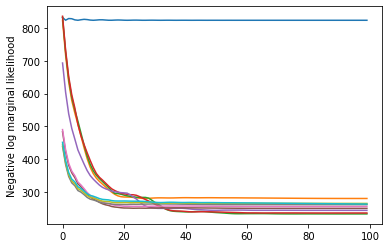

In [ ]:
losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

Text(0.5, 1.0, 'Model selection on latent states')

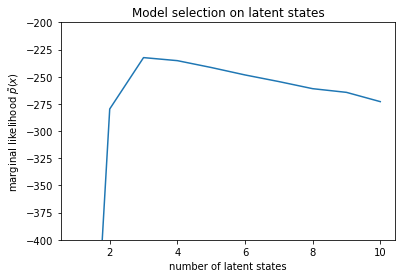

In [ ]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -losses[-1])
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

检查似然时，我们发现（近似）边缘似然倾向于包含三种状态的模型。这看似非常合理，“真实”模型具有四种状态，但仅仅查看数据的话，很难排除具有三种状态的模型说明。


我们也可以提取每个候选模型的比率拟合：

In [ ]:
rates = tf.exp(trainable_log_rates)
for i, learned_model_rates in enumerate(rates):
  print("rates for {}-state model: {}".format(i+1, learned_model_rates[:i+1]))

rates for 1-state model: [32.968506]
rates for 2-state model: [ 5.789209 47.948917]
rates for 3-state model: [ 2.841977 48.057507 17.958897]
rates for 4-state model: [ 2.8302798 49.585037  41.928406  17.351114 ]
rates for 5-state model: [17.399694  77.83679   41.975216  49.62771    2.8256145]
rates for 6-state model: [41.63677   77.20768   49.570934  49.557076  17.630419   2.8713436]
rates for 7-state model: [41.711704  76.405945  49.581184  49.561283  17.451889   2.8722699
 17.43608  ]
rates for 8-state model: [41.771793 75.41323  49.568714 49.591846 17.2523   17.247969 17.231388
  2.830598]
rates for 9-state model: [41.83378   74.50916   49.619488  49.622494   2.8369408 17.254414
 17.21532    2.5904858 17.252514 ]
rates for 10-state model: [4.1886074e+01 7.3912338e+01 4.1940136e+01 4.9652588e+01 2.8485537e+00
 1.7433832e+01 6.7564294e-02 1.9590002e+00 1.7430998e+01 7.8838937e-02]


同时绘制每个模型为数据提供的说明：

In [ ]:
most_probable_states = hmm.posterior_mode(observed_counts)

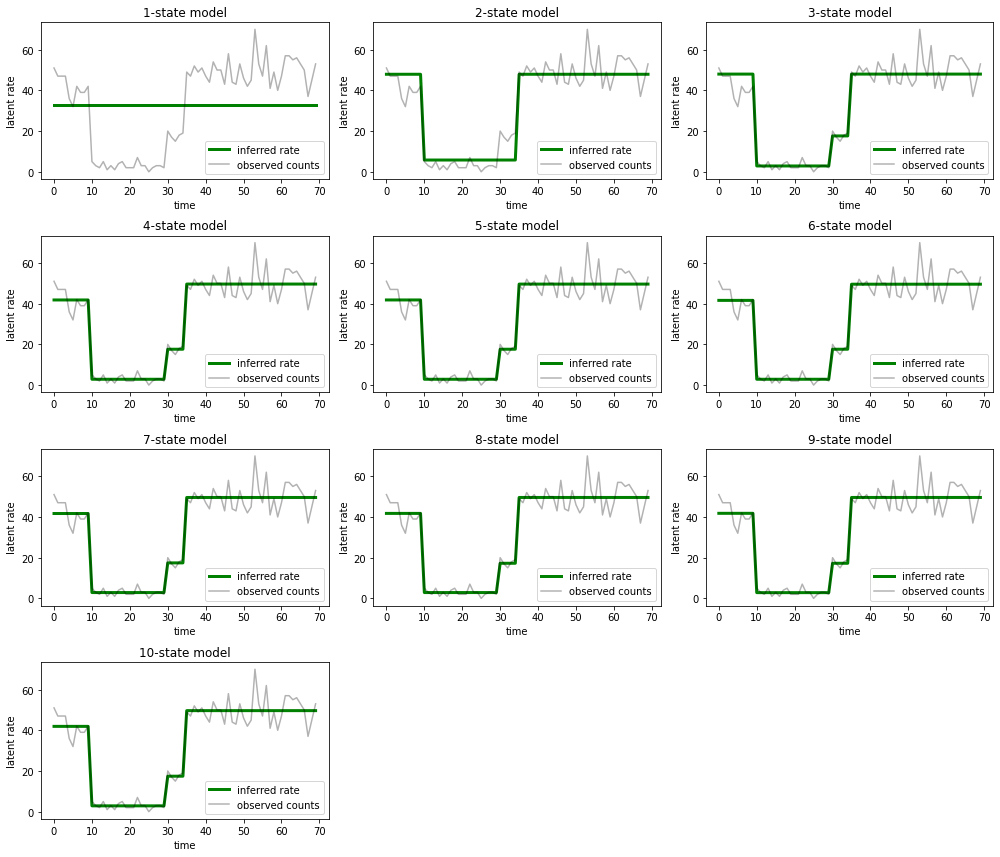

In [ ]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
  ax = fig.add_subplot(4, 3, i+1)
  ax.plot(tf.gather(learned_model_rates, most_probable_states[i]), c='green', lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()

很容易便可了解包含一种状态、两种状态和（更精细的）三种状态的模型为何提供的说明不足。有趣的是，超过四种状态的所有模型基本上会提供相同的说明！这可能是因为我们的“数据”相对清晰，几乎没有留出备选说明的空间；真实环境中的数据较为凌乱，我们希望容量较高的模型能够更好地逐步拟合数据，在某个折衷点，模型的复杂性会胜过改进的拟合。

### 延伸内容

可以通过多种方式直接扩展此笔记本中的模型。例如：

- 允许隐状态具有不同的概率（有些状态可能很常见，有些状态可能很罕见）
- 允许隐状态之间的转移不一致（例如，得知机器崩溃后通常会重新启动系统，之后通常有一段时间性能良好，等等）
- 其他发射模型（例如，`NegativeBinomial`，用于对计数数据的各种离差建模），或者连续分布（例如，用于实值数据的 `Normal`）。
